<a href="https://colab.research.google.com/github/Alphaomegainfinity/yahoo_stocks_market/blob/main/yahoo_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install yfinance
!pip install ipympl

In [32]:
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()

# import dependencies
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import os
from tqdm import tqdm

# import sqlalchemy for database connection
from sqlalchemy import create_engine
from sqlalchemy import inspect
from sqlalchemy.orm import sessionmaker

#Config should contain database username as username and database password as password
# from config import password

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

In [3]:
url = 'https://finance.yahoo.com/world-indices'
tables = pd.read_html(url)
world_stocks = tables[0]
world_stocks

,Symbol,Name,Last Price,Change,% Change,Volume,Intraday High/Low,52 Week Range,Day Chart
0,^GSPC,S&P 500,4405.71,29.40,+0.67%,NaN,NaN,NaN,NaN
1,^DJI,Dow 30,34346.90,247.48,+0.73%,NaN,NaN,NaN,NaN
2,^IXIC,Nasdaq,13590.65,126.67,+0.94%,NaN,NaN,NaN,NaN
3,^NYA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,^XAX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,^BUK100P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,^RUT,Russell 2000,1853.63,7.35,+0.40%,NaN,NaN,NaN,NaN
7,^VIX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,^FTSE,FTSE 100,7338.58,4.95,+0.07%,NaN,NaN,NaN,NaN
9,^GDAXI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def fetch_data(ticker_symbol):
    try:
        ticker = yf.Ticker(ticker_symbol)
        today = datetime.date.today().strftime('%Y-%m-%d')
        data = ticker.history(start="1900-01-01", end=today)
        data.reset_index(inplace=True)
        data['ticker'] = ticker_symbol
        return data
    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return None

In [5]:
all_data = []
for symbol in tqdm(world_stocks['Symbol'], desc="Fetching data"):  # tqdm progress bar!
    single_data = fetch_data(symbol)
    if single_data is not None:
        all_data.append(single_data)

# Concatenate all the individual datasets into one
master_data_origin = pd.concat(all_data, ignore_index=True)
master_data_origin

Fetching data: 100%|██████████| 36/36 [00:28<00:00,  1.28it/s]


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,Adj Close
0,1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0.0,0.0,0.0,^GSPC,NaN
1,1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0.0,0.0,0.0,^GSPC,NaN
2,1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0.0,0.0,0.0,^GSPC,NaN
3,1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0.0,0.0,0.0,^GSPC,NaN
4,1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0.0,0.0,0.0,^GSPC,NaN
...,...,...,...,...,...,...,...,...,...,...
284140,2023-08-21 00:00:00+02:00,3818.739990,3889.449951,3816.969971,3861.469971,0.0,0.0,0.0,^JN0U.JO,NaN
284141,2023-08-22 00:00:00+02:00,3891.000000,3950.280029,3873.770020,3883.989990,0.0,0.0,0.0,^JN0U.JO,NaN
284142,2023-08-23 00:00:00+02:00,3887.750000,3977.760010,3886.830078,3975.689941,0.0,0.0,0.0,^JN0U.JO,NaN
284143,2023-08-24 00:00:00+02:00,3969.169922,4003.260010,3929.610107,3947.600098,0.0,0.0,0.0,^JN0U.JO,NaN


In [6]:
# Checking any missing values per column and per rows
def data_checking(master_data_check):
    # Identify NaN or empty values
    missing_values = master_data_check.isna().sum()

    # Identify incorrect value types
    incorrect_types = master_data_check.apply(lambda x: pd.to_numeric(x, errors='coerce').isna().sum())

    # Combine the results into a DataFrame
    cleaning_report = pd.DataFrame({'Missing Values': missing_values, 'Incorrect Types': incorrect_types})

    return cleaning_report

In [7]:
data_checking(master_data_origin)

,Missing Values,Incorrect Types
Date,0,284145
Open,0,0
High,0,0
Low,0,0
Close,0,0
Volume,0,0
Dividends,0,0
Stock Splits,0,0
ticker,0,284145
Adj Close,284145,284145


In [8]:
# Copy the dataframe
master_data = master_data_origin.copy()

In [9]:
# Drop off the Adj Close column
master_data = master_data.drop(columns=['Adj Close'])

# Correct the Date column data type
master_data['Date'] = pd.to_datetime(master_data['Date'], utc = True)
master_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
0,1927-12-30 05:00:00+00:00,17.660000,17.660000,17.660000,17.660000,0.0,0.0,0.0,^GSPC
1,1928-01-03 05:00:00+00:00,17.760000,17.760000,17.760000,17.760000,0.0,0.0,0.0,^GSPC
2,1928-01-04 05:00:00+00:00,17.719999,17.719999,17.719999,17.719999,0.0,0.0,0.0,^GSPC
3,1928-01-05 05:00:00+00:00,17.549999,17.549999,17.549999,17.549999,0.0,0.0,0.0,^GSPC
4,1928-01-06 05:00:00+00:00,17.660000,17.660000,17.660000,17.660000,0.0,0.0,0.0,^GSPC


In [10]:
# rearrange the columns and remove the hour from the date
master_data = master_data[['ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
master_data['Date'] = pd.to_datetime((master_data['Date']).dt.date)

# remove '^' from the ticker
master_data['ticker'] = master_data['ticker'].str.replace('^', '').astype(str)
master_data

<ipython-input-10-f1ffa0fcbe6d>:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  master_data['ticker'] = master_data['ticker'].str.replace('^', '').astype(str)


,ticker,Date,Open,High,Low,Close,Volume
0,GSPC,1927-12-30,17.660000,17.660000,17.660000,17.660000,0.0
1,GSPC,1928-01-03,17.760000,17.760000,17.760000,17.760000,0.0
2,GSPC,1928-01-04,17.719999,17.719999,17.719999,17.719999,0.0
3,GSPC,1928-01-05,17.549999,17.549999,17.549999,17.549999,0.0
4,GSPC,1928-01-06,17.660000,17.660000,17.660000,17.660000,0.0
...,...,...,...,...,...,...,...
284140,JN0U.JO,2023-08-20,3818.739990,3889.449951,3816.969971,3861.469971,0.0
284141,JN0U.JO,2023-08-21,3891.000000,3950.280029,3873.770020,3883.989990,0.0
284142,JN0U.JO,2023-08-22,3887.750000,3977.760010,3886.830078,3975.689941,0.0
284143,JN0U.JO,2023-08-23,3969.169922,4003.260010,3929.610107,3947.600098,0.0


In [11]:
master_data.dtypes

ticker            object
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object

In [12]:
data_checking(master_data)

,Missing Values,Incorrect Types
ticker,0,284145
Date,0,0
Open,0,0
High,0,0
Low,0,0
Close,0,0
Volume,0,0


In [13]:
# Adding "Movement" column to calculate the difference movement during a trading day
# master_data ['Movement'] = master_data ['Close'] - master_data ['Open']

# master_data['Color'] = master_data['Movement'].apply(lambda x: 'green' if x >= 0 else 'red')

In [14]:
# create a list of unique stock symbols
stock_symbols = master_data['ticker'].unique().tolist()

# Split data into individual stocks
individual_stocks = {}
for ticker_name in master_data['ticker'].unique():
    individual_stocks[ticker_name] = master_data[master_data['ticker'] == ticker_name]
    individual_stocks[ticker_name].reset_index(inplace=True, drop=True)

individual_stocks['GSPC']

,ticker,Date,Open,High,Low,Close,Volume,Movement,Color
0,GSPC,1927-12-30,17.660000,17.660000,17.660000,17.660000,0.000000e+00,0.000000,green
1,GSPC,1928-01-03,17.760000,17.760000,17.760000,17.760000,0.000000e+00,0.000000,green
2,GSPC,1928-01-04,17.719999,17.719999,17.719999,17.719999,0.000000e+00,0.000000,green
3,GSPC,1928-01-05,17.549999,17.549999,17.549999,17.549999,0.000000e+00,0.000000,green
4,GSPC,1928-01-06,17.660000,17.660000,17.660000,17.660000,0.000000e+00,0.000000,green
...,...,...,...,...,...,...,...,...,...
24023,GSPC,2023-08-21,4380.279785,4407.549805,4360.299805,4399.770020,3.726850e+09,19.490234,green
24024,GSPC,2023-08-22,4415.330078,4418.589844,4382.770020,4387.549805,3.522760e+09,-27.780273,red
24025,GSPC,2023-08-23,4396.439941,4443.180176,4396.439941,4436.009766,3.837270e+09,39.569824,green
24026,GSPC,2023-08-24,4455.160156,4458.299805,4375.549805,4376.310059,3.723470e+09,-78.850098,red


In [15]:
print (stock_symbols)

['GSPC', 'DJI', 'IXIC', 'NYA', 'XAX', 'BUK100P', 'RUT', 'VIX', 'FTSE', 'GDAXI', 'FCHI', 'STOXX50E', 'N100', 'BFX', 'IMOEX.ME', 'N225', 'HSI', '000001.SS', '399001.SZ', 'STI', 'AXJO', 'AORD', 'BSESN', 'JKSE', 'KLSE', 'NZ50', 'KS11', 'TWII', 'GSPTSE', 'BVSP', 'MXX', 'IPSA', 'MERV', 'TA125.TA', 'JN0U.JO']


In [27]:
data = individual_stocks['JKSE'].copy()
data.set_index('Date', inplace=True)
data=data.asfreq('B') # 'B' is for business days
# Drop off all rows that have more than 5 missing values
data = data.dropna(thresh=len(data.columns)-5)

data

,ticker,Open,High,Low,Close,Volume,Movement,Color
Date,,,,,,,,
1990-04-05,JKSE,641.268982,641.268982,641.268982,641.268982,0.0,0.000000,green
1990-04-09,JKSE,632.085999,632.085999,632.085999,632.085999,0.0,0.000000,green
1990-04-10,JKSE,634.692993,634.692993,634.692993,634.692993,0.0,0.000000,green
1990-04-11,JKSE,639.614014,639.614014,639.614014,639.614014,0.0,0.000000,green
1990-04-16,JKSE,641.872986,641.872986,641.872986,641.872986,0.0,0.000000,green
...,...,...,...,...,...,...,...,...
2023-08-17,JKSE,6899.830078,6899.830078,6856.378906,6859.912109,130737900.0,-39.917969,red
2023-08-21,JKSE,6866.033203,6927.448242,6860.688965,6916.450195,158573900.0,50.416992,green
2023-08-22,JKSE,6916.450195,6959.432129,6916.450195,6921.410156,170674700.0,4.959961,green


In [33]:

features = ['Open', 'High', 'Low']
target = 'Close'

X = data[features]
y = data[target]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize models
arima_model = ARIMA(y_train, order=(5, 1, 0))
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)

# LSTM requires 3D input
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train models
arima_model_fit = arima_model.fit()
rf_model.fit(X_train_scaled, y_train)
gb_model.fit(X_train_scaled, y_train)
lstm_model.fit(X_train_lstm, y_train, epochs=1000, batch_size=32, validation_data=(X_test_lstm, y_test), callbacks=[early_stopping])

# Predictions
arima_preds = arima_model_fit.forecast(steps=len(y_test))
rf_preds = rf_model.predict(X_test_scaled)
gb_preds = gb_model.predict(X_test_scaled)
lstm_preds = lstm_model.predict(X_test_lstm)
lstm_preds = lstm_preds.reshape(-1)

# Create a date-based index for forecasted results, indexing based on business days.
forecast_start_date = y_test.index[0]
forecast_periods = len(arima_preds)
forecast_index = pd.bdate_range(start=forecast_start_date, periods=forecast_periods, freq='C', weekmask='1001000')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

Epoch 1/1000
163/163 [==============================] - 5s 10ms/step - loss: 12262302.0000 - val_loss: 12079164.0000
Epoch 2/1000
163/163 [==============================] - 1s 4ms/step - loss: 12224526.0000 - val_loss: 12030603.0000
Epoch 3/1000
163/163 [==============================] - 1s 4ms/step - loss: 12175535.0000 - val_loss: 11985222.0000
Epoch 4/1000
163/163 [==============================] - 1s 4ms/step - loss: 12132543.0000 - val_loss: 11945309.0000
Epoch 5/1000
163/163 [==============================] - 1s 6ms/step - loss: 12093746.0000 - val_loss: 11908369.0000
Epoch 6/1000
163/163 [==============================] - 1s 7ms/step - loss: 12057299.0000 - val_loss: 11873146.0000
Epoch 7/1000
163/163 [==============================] - 1s 7ms/step - loss: 12022107.0000 - val_loss: 11838976.0000
Epoch 8/1000
163/163 [==============================] - 1s 7ms/step - loss: 11987600.0000 - val_loss: 11805047.0000
Epoch 9/1000
163/163 [==============================] - 1s 4ms/step - l

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


41/41 [==============================] - 1s 2ms/step


In [34]:
# Evaluate models
print("ARIMA")
print("MSE:", mean_squared_error(y_test, arima_preds))
print("MAE:", mean_absolute_error(y_test, arima_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, arima_preds)))

print("\nRandom Forest")
print("MSE:", mean_squared_error(y_test, rf_preds))
print("MAE:", mean_absolute_error(y_test, rf_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, rf_preds)))

print("\nGradient Boosting")
print("MSE:", mean_squared_error(y_test, gb_preds))
print("MAE:", mean_absolute_error(y_test, gb_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, gb_preds)))

print("\nLSTM")
print("MSE:", mean_squared_error(y_test, lstm_preds))
print("MAE:", mean_absolute_error(y_test, lstm_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, lstm_preds)))

# Print the forecasted results with proper date index
forecast_df = pd.DataFrame({'ARIMA': arima_preds, 'RF': rf_preds, 'GB': gb_preds, 'LSTM': lstm_preds}, index=forecast_index)
print(forecast_df)

ARIMA
MSE: 6499520.572471078
MAE: 2360.5986746987414
RMSE: 2549.4157315885295

Random Forest
MSE: 297.1079511658828
MAE: 9.156962390352192
RMSE: 17.236819636054754

Gradient Boosting
MSE: 493.4660839520862
MAE: 13.705076459444237
RMSE: 22.21409651442269

LSTM
MSE: 51031.224437376426
MAE: 74.27712997471654
RMSE: 225.90091730087426
            ARIMA           RF           GB         LSTM
2020-08-20    NaN  5302.437915  5306.948235  5298.537109
2020-08-24    NaN   580.576832   569.646814   565.903503
2020-08-27    NaN   470.807194   473.031733   471.291504
2020-08-31    NaN  6218.783164  6234.445383  5993.586426
2020-09-03    NaN  6357.126816  6321.766564  5997.390137
...           ...          ...          ...          ...
2033-01-27    NaN  7030.848247  7018.795675  6000.185059
2033-01-31    NaN  4726.086377  4707.317621  4729.467773
2033-02-03    NaN  3830.853965  3829.215111  3831.203125
2033-02-07    NaN  2929.817979  2943.428657  2925.572021
2033-02-10    NaN   564.657527   560.7316

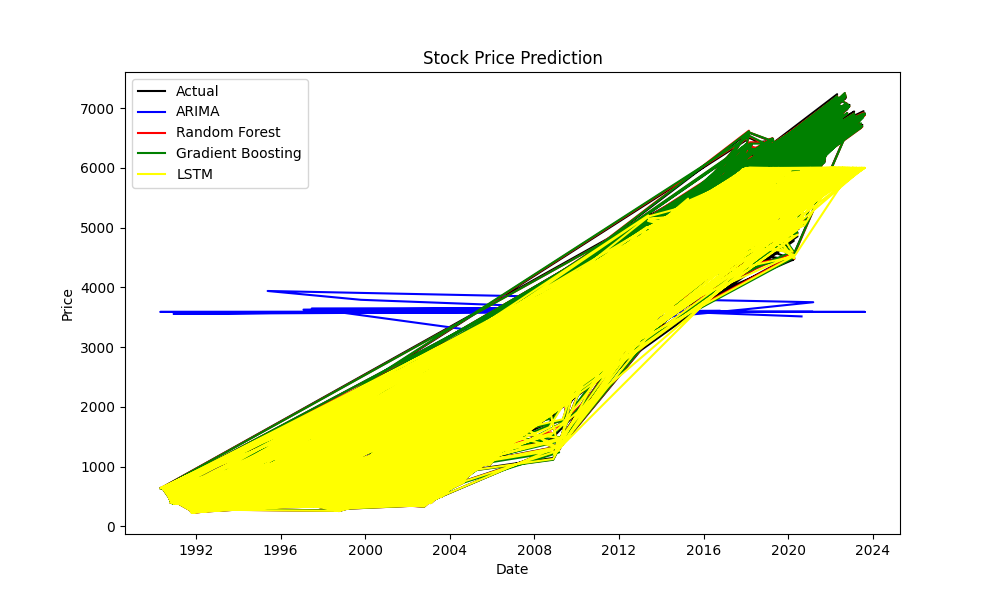

In [35]:
# Plot actual vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='Actual', color='black')
plt.plot(y_test.index, arima_preds, label='ARIMA', color='blue')
plt.plot(y_test.index, rf_preds, label='Random Forest', color='red')
plt.plot(y_test.index, gb_preds, label='Gradient Boosting', color='green')
plt.plot(y_test.index, lstm_preds, label='LSTM', color='yellow')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Prediction')
plt.show()